In [5]:
import zipfile
import os

def unzip_file(zip_path, extract_to):
    """
    Unzips a zip file to a specified directory

    Args:
        zip_path (str): Path to the zip file
        extract_to (str): Directory where contents will be extracted
    """
    # Create the extraction directory if it doesn't exist
    os.makedirs(extract_to, exist_ok=True)

    # Open the zip file in read mode
    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
        # Extract all contents to the target directory
        zip_ref.extractall(extract_to)

    print(f"Successfully extracted {zip_path} to {extract_to}")

# Example usage:
zip_file = '/content/hymenoptera_data.zip'  # Path to your zip file
destination = '/content/hymenoptera_data'  # Directory to extract to
unzip_file(zip_file, destination)

Successfully extracted /content/hymenoptera_data.zip to /content/hymenoptera_data


Using device: cpu
Class names: ['ants', 'bees']
Train dataset size: 244
Validation dataset size: 153


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


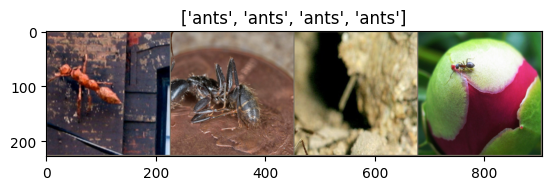

In [8]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, f1_score
from sklearn.preprocessing import StandardScaler

# Set random seeds for reproducibility
torch.manual_seed(42)
np.random.seed(42)

# Check for CUDA
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Data augmentation and normalization for training
# Just normalization for validation
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

# Load the dataset with the correct structure
data_dir = '/content/hymenoptera_data/hymenoptera_data'
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                  data_transforms[x])
              for x in ['train', 'val']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4,
                                             shuffle=True, num_workers=4)
              for x in ['train', 'val']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
class_names = image_datasets['train'].classes

print(f"Class names: {class_names}")
print(f"Train dataset size: {dataset_sizes['train']}")
print(f"Validation dataset size: {dataset_sizes['val']}")

# Visualize a few images
def imshow(inp, title=None):
    """Display image for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated

# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

# Feature Extraction Function

In [9]:
def extract_resnet_features(model, dataloader, device):
    """
    Extract features from ResNet18 model for all images in a dataloader

    Args:
        model: Pretrained ResNet18 model
        dataloader: PyTorch dataloader containing images
        device: Device to run computation on (CPU/GPU)

    Returns:
        features_array: Nx512 numpy array of features
        labels_array: Nx1 numpy array of corresponding labels
    """
    model.eval()  # Set model to evaluation mode
    features = []
    labels = []

    with torch.no_grad():  # No need to track gradients
        for inputs, targets in dataloader:
            inputs = inputs.to(device)

            # Forward pass through the model
            outputs = model(inputs)

            # Convert to numpy arrays and store
            features.append(outputs.cpu().numpy())
            labels.append(targets.numpy())

    # Concatenate all batches
    features_array = np.concatenate(features, axis=0)
    labels_array = np.concatenate(labels, axis=0)

    # Reshape from (N, 1, 512) to (N, 512)
    features_array = features_array.reshape(features_array.shape[0], -1)

    return features_array, labels_array

# Load pretrained ResNet18
model_ft = models.resnet18(pretrained=True)

# Remove the final fully connected layer to get 512-dim features
model_ft = torch.nn.Sequential(*(list(model_ft.children())[:-1]))

# Freeze all layers
for param in model_ft.parameters():
    param.requires_grad_(False)

# Move model to the right device
model_ft = model_ft.to(device)

# Extract features for training and validation sets
train_features, train_labels = extract_resnet_features(model_ft, dataloaders['train'], device)
val_features, val_labels = extract_resnet_features(model_ft, dataloaders['val'], device)

print(f"Train features shape: {train_features.shape}")  # Should be Nx512
print(f"Train labels shape: {train_labels.shape}")
print(f"Validation features shape: {val_features.shape}")
print(f"Validation labels shape: {val_labels.shape}")

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 51.0MB/s]


Train features shape: (244, 512)
Train labels shape: (244,)
Validation features shape: (153, 512)
Validation labels shape: (153,)


# Model Training and Evaluation

In [10]:
# Standardize features (important for SVM with RBF kernel)
scaler = StandardScaler()
train_features_scaled = scaler.fit_transform(train_features)
val_features_scaled = scaler.transform(val_features)

# SVM with RBF kernel - Grid Search
print("\nTraining SVM with RBF kernel...")
svm_params = {
    'C': [0.1, 1, 10, 100],
    'gamma': ['scale', 'auto', 0.001, 0.01, 0.1]
}
svm = SVC(kernel='rbf', probability=True, random_state=42)
svm_grid = GridSearchCV(svm, svm_params, cv=5, n_jobs=-1, verbose=1)
svm_grid.fit(train_features_scaled, train_labels)

# Print best SVM parameters
print(f"Best SVM parameters: {svm_grid.best_params_}")
print(f"Best cross-validation score: {svm_grid.best_score_:.3f}")

# Evaluate on validation set
svm_val_pred = svm_grid.predict(val_features_scaled)
svm_val_acc = accuracy_score(val_labels, svm_val_pred)
svm_val_f1 = f1_score(val_labels, svm_val_pred, average='weighted')
print(f"SVM Validation Accuracy: {svm_val_acc:.3f}")
print(f"SVM Validation F1 Score: {svm_val_f1:.3f}")

# Random Forest - Grid Search
print("\nTraining Random Forest...")
rf_params = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10]
}
rf = RandomForestClassifier(random_state=42)
rf_grid = GridSearchCV(rf, rf_params, cv=5, n_jobs=-1, verbose=1)
rf_grid.fit(train_features, train_labels)  # RF doesn't need scaled features

# Print best RF parameters
print(f"Best RF parameters: {rf_grid.best_params_}")
print(f"Best cross-validation score: {rf_grid.best_score_:.3f}")

# Evaluate on validation set
rf_val_pred = rf_grid.predict(val_features)
rf_val_acc = accuracy_score(val_labels, rf_val_pred)
rf_val_f1 = f1_score(val_labels, rf_val_pred, average='weighted')
print(f"RF Validation Accuracy: {rf_val_acc:.3f}")
print(f"RF Validation F1 Score: {rf_val_f1:.3f}")

# Compare models
print("\nModel Comparison:")
print(f"{'Model':<20}{'Validation Accuracy':<20}{'Validation F1':<20}")
print(f"{'SVM (RBF)':<20}{svm_val_acc:.3f}{'':<17}{svm_val_f1:.3f}")
print(f"{'Random Forest':<20}{rf_val_acc:.3f}{'':<17}{rf_val_f1:.3f}")

# Save models for deployment
import pickle

with open('svm_model.pkl', 'wb') as f:
    pickle.dump(svm_grid.best_estimator_, f)

with open('rf_model.pkl', 'wb') as f:
    pickle.dump(rf_grid.best_estimator_, f)

with open('scaler.pkl', 'wb') as f:
    pickle.dump(scaler, f)


Training SVM with RBF kernel...
Fitting 5 folds for each of 20 candidates, totalling 100 fits
Best SVM parameters: {'C': 1, 'gamma': 'scale'}
Best cross-validation score: 0.934
SVM Validation Accuracy: 0.954
SVM Validation F1 Score: 0.954

Training Random Forest...
Fitting 5 folds for each of 36 candidates, totalling 180 fits
Best RF parameters: {'max_depth': None, 'min_samples_split': 5, 'n_estimators': 200}
Best cross-validation score: 0.926
RF Validation Accuracy: 0.948
RF Validation F1 Score: 0.948

Model Comparison:
Model               Validation Accuracy Validation F1       
SVM (RBF)           0.954                 0.954
Random Forest       0.948                 0.948
